In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch
import config

from utils import show_abundance, plot_endmembers
from HySpecLab.metrics import rmse, sad
from scipy import io as sio

/home/abian/Workspace/Anaconda/envs/CLHU/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dataset import Cuprite

dataset = Cuprite(config.Cuprite_PATH)
result_path = os.path.join(config.RESULTS_PATH, 'cuprite')

# Ground Truth

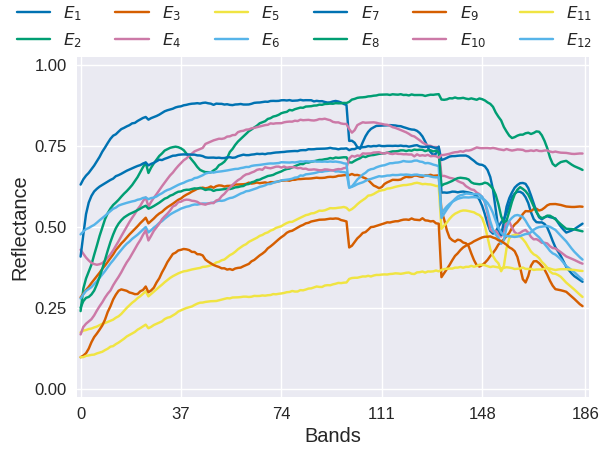

In [3]:
from utils import plot_endmembers, show_abundance
fig = plot_endmembers(dataset.endmembers(), ticks_range=(0, 1))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_ref.pdf'), bbox_inches='tight')

# fig = show_abundance(dataset.abundance())
# plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/A_ref.png'), dpi=300, bbox_inches='tight')

In [5]:
from HySpecLab.metrics import sad

def sort_endmember(endmembers, gt):
    sad_result = sad(endmembers, gt)
    e_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth
    return e_idx, sad_result

[ 0  2  4  6  7  8 11]


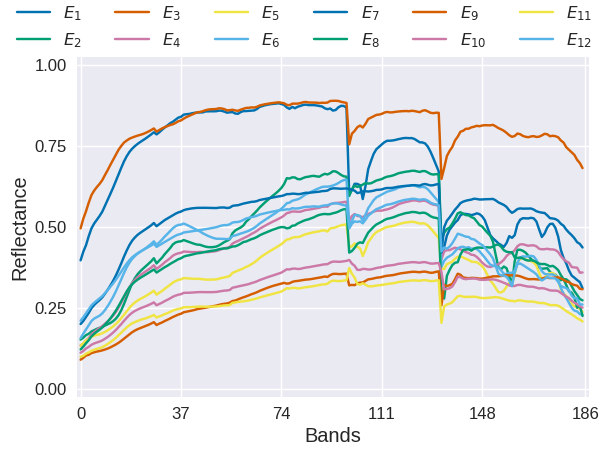

In [6]:
from HySpecLab.eea import VCA

n_endmembers = dataset.n_endmembers
   
vca = VCA(n_endmembers, snr_input=30, random_state=42)
vca.fit(dataset.X.numpy())
endmembers = torch.from_numpy(vca.endmembers()).float()
e_idx, sad_result = sort_endmember(endmembers, dataset.endmembers())
print(np.unique(e_idx))

vca_endmember_init = endmembers
vca_logit_endmember_init = torch.log((vca_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(vca_endmember_init, ticks_range=(0, 1))
plt.show(fig)

# fig.savefig(os.path.join(result_path, 'imgs/M_vca.pdf'), bbox_inches='tight')

[ 0  1  2  3  6  7  8  9 10 11]


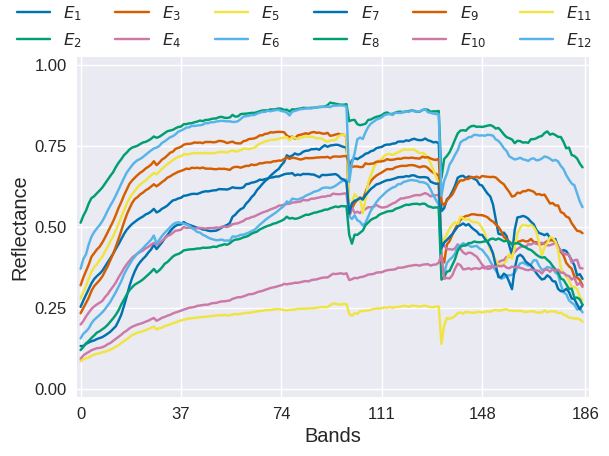

In [7]:
from utils import plot_endmembers
from pysptools import eea
n_endmembers = dataset.n_endmembers

ee = eea.NFINDR()
endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()

e_idx, _ = sort_endmember(endmember, dataset.endmembers())
# e_idx[2] = 3
print(np.unique(e_idx))
nfindr_endmember_init = endmember
nfindr_logit_endmember_init = torch.log((nfindr_endmember_init + 1e-12) / ((1-nfindr_endmember_init) + 1e-12))

fig = plot_endmembers(nfindr_endmember_init, ticks_range=(0, 1))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_nfindr.pdf'), bbox_inches='tight')

# PPI

In [8]:
ee = eea.PPI()
endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()



[ 0  1  2  3  6  7  9 10]


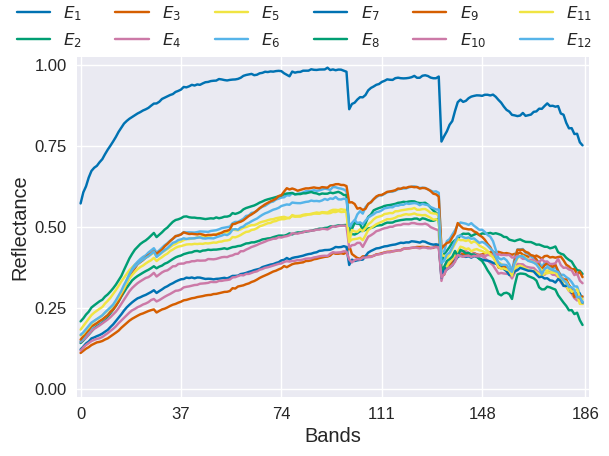

In [61]:
ppi_endmember_init = endmember
ppi_logit_endmember_init = torch.log((ppi_endmember_init + 1e-12) / ((1-ppi_endmember_init) + 1e-12))
e_idx, _ = sort_endmember(endmember, dataset.endmembers())
print(np.unique(e_idx))

fig = plot_endmembers(ppi_endmember_init, ticks_range=(0, 1))
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/M_ppi.pdf'), bbox_inches='tight')

# ATGP

[ 0  1  2  5  7  8 10 11]


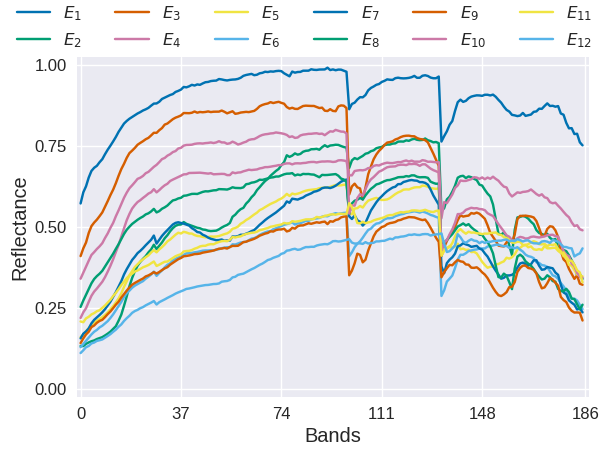

In [62]:
ee = eea.ATGP()
endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()

atgp_endmember_init = endmember
atgp_logit_endmember_init = torch.log((atgp_endmember_init + 1e-12) / ((1-atgp_endmember_init) + 1e-12))
e_idx, _ = sort_endmember(endmember, dataset.endmembers())
print(np.unique(e_idx))

fig = plot_endmembers(atgp_endmember_init, ticks_range=(0, 1))
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/M_atgp.pdf'), bbox_inches='tight')

In [231]:
dict = {'NFINDR': nfindr_endmember_init.numpy(), 'VCA': vca_endmember_init.numpy(), 'PPI': ppi_endmember_init.numpy(),
        'ATGP': atgp_endmember_init.numpy()}
sio.savemat(os.path.join(result_path, 'matlab/endmembers.mat'), dict)

In [232]:
# endmember_init_method = 'nfindr'
# endmember_init = nfindr_endmember_init
# logit_endmember_init = nfindr_logit_endmember_init

endmember_init_method = 'vca'
endmember_init = vca_endmember_init
logit_endmember_init = vca_logit_endmember_init

# endmember_init_method = 'ppi'
# endmember_init = ppi_endmember_init
# logit_endmember_init = ppi_logit_endmember_init

# endmember_init_method = 'atgp'
# endmember_init = atgp_endmember_init
# logit_endmember_init = atgp_logit_endmember_init

In [233]:
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
from HySpecLab.metrics import UnmixingLoss
from torch.utils.data import Dataset, DataLoader
from torch import sigmoid, nn
from tqdm import tqdm
import torch

def train(model:nn.Module, n_endmembers:int, dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3, similarity_weight=.5, simplex_weight=1e-5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    criterion = UnmixingLoss() 
    volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers).to(device)
    similarity_reg = SimilarityLoss(n_endmembers, temperature=1e-3, reduction='mean')
    vol_reg_norm = volume_reg(torch.sigmoid(model.ebk.detach()))

    dataloader = DataLoader(dataset, batch_size=int(len(dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )
    
    scaler = torch.cuda.amp.GradScaler()

    for _ in epoch_iterator:
        epoch_loss = 0.
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + simplex_weight*(volume_reg(sigmoid(model.ebk))/vol_reg_norm) + similarity_weight*similarity_reg(model.ebk)
            epoch_loss += loss.detach().item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)))

In [234]:
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

similarity_reg = SimilarityLoss(n_endmembers, temperature=1e-3, reduction='mean')
similarity_reg(dataset.endmembers()), similarity_reg(endmember_init)

(tensor(0.0800), tensor(0.2123))

# Training

In [245]:
# from utils import train 
from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, similarity_weight=1, simplex_weight=1e-2)

100%|██████████| 50/50 [00:24<00:00,  2.01epoch/s, tls=0.0359]


# Save model

In [246]:
torch.save(model.state_dict(), os.path.join(result_path, 'clhu/weights/clhu_{}.pth'.format(endmember_init_method)))

# Testing model

In [247]:
# load model
model = ContrastiveUnmixing(dataset.n_bands, dataset.n_endmembers)

model.load_state_dict(torch.load(os.path.join(result_path, 'clhu/weights/clhu_{}.pth'.format(endmember_init_method))))
model = model.eval()

In [248]:
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy

criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=1e-3, reduction='mean')

In [251]:
from torch import sigmoid 
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0177) tensor(0.8368) tensor(4.0651e-24) tensor(0.0484)


In [252]:
volume_reg(endmember_init), similarity_reg(endmember_init)

(tensor(6.2337e-17), tensor(0.2123))

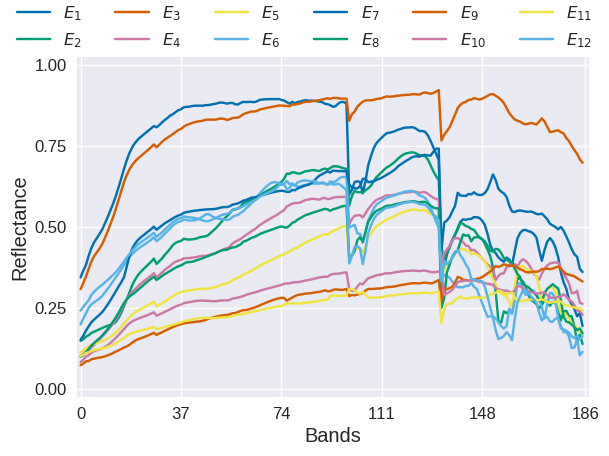

In [253]:
ebk = torch.sigmoid(model.ebk).detach().cpu()

fig = plot_endmembers(ebk, ticks_range=(0, 1))
plt.show(fig)
fig.savefig(os.path.join(result_path, 'clhu/imgs/M_clhu_{}.pdf'.format(endmember_init_method)), bbox_inches='tight')

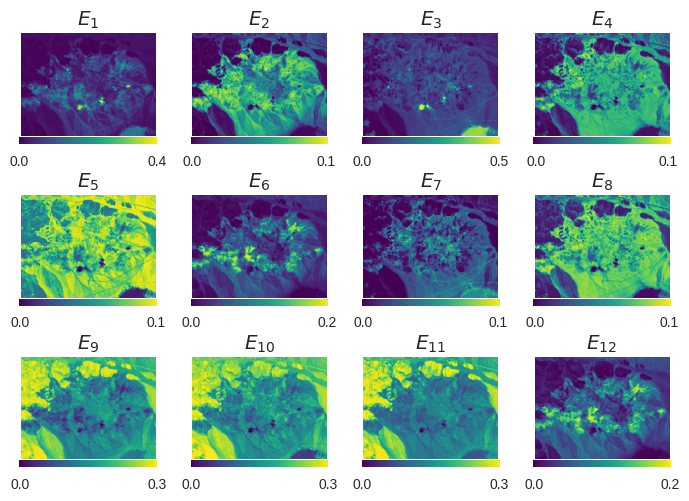

In [254]:
from torch.nn.functional import softmax
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, -1)

fig = show_abundance(test)
plt.show(fig)

fig.savefig(os.path.join(result_path, 'clhu/imgs/A_clhu_{}.png'.format(endmember_init_method)), dpi=300, bbox_inches='tight')

In [255]:
M_hat = torch.sigmoid(model.ebk).detach().cpu()
e_idx, sad_result = sort_endmember(M_hat, dataset.endmembers())
print(len(np.unique(e_idx)))

print(e_idx)
# print(sad_result)
print(sad_result[np.arange(12), e_idx])

# sad_result as df
import pandas as pd
sad_df = pd.DataFrame(sad_result, columns=['E_{}'.format(i) for i in range(1, n_endmembers+1)])
index = ['Ê_{}'.format(i) for i in range(1, n_endmembers+1)]
sad_df.index = index
sad_df.to_csv(os.path.join(result_path, 'clhu/sad_clhu_{}.csv'.format(endmember_init_method)))

sad_df

7
tensor([ 0,  2,  2,  3,  4,  6,  2,  2,  6, 10,  8,  2])
tensor([0.1158, 0.2603, 0.1298, 0.1426, 0.0732, 0.2395, 0.1541, 0.2182, 0.3287,
        0.1334, 0.1401, 0.2484])


,E_1,E_2,E_3,E_4,E_5,E_6,E_7,E_8,E_9,E_10,E_11,E_12
Ê_1,0.115837,0.291471,0.217526,0.161823,0.328308,0.209204,0.206847,0.234739,0.266122,0.363381,0.423970,0.172527
Ê_2,0.279965,0.264354,0.260330,0.159116,0.193401,0.183568,0.272199,0.226860,0.209327,0.322888,0.362171,0.252045
Ê_3,0.241385,0.064474,0.129846,0.176817,0.175713,0.113043,0.142730,0.073488,0.118696,0.105579,0.163449,0.146456
Ê_4,0.273021,0.162464,0.176711,0.142581,0.106966,0.117409,0.222752,0.138556,0.116417,0.202698,0.242625,0.208942
Ê_5,0.315136,0.178909,0.237339,0.198384,0.073172,0.147213,0.248462,0.169634,0.136922,0.222476,0.242104,0.247261
Ê_6,0.174568,0.295919,0.224958,0.145745,0.290779,0.204163,0.239515,0.240025,0.255935,0.366545,0.422042,0.207695
Ê_7,0.261694,0.092655,0.154099,0.164674,0.126615,0.097944,0.180892,0.087255,0.076106,0.132407,0.178150,0.177346
Ê_8,0.266010,0.180048,0.218205,0.150981,0.131430,0.120871,0.225096,0.154979,0.107439,0.234005,0.271605,0.209420
Ê_9,0.436207,0.203586,0.287929,0.351593,0.233744,0.283744,0.328700,0.252510,0.243185,0.116970,0.068741,0.337036
Ê_10,0.291404,0.078943,0.167232,0.191553,0.110152,0.121411,0.196226,0.100896,0.095843,0.094462,0.133427,0.198598


In [256]:
sad_result[np.arange(12),e_idx].mean()

tensor(0.1820)

In [257]:
e_idx, sad_result = sort_endmember(endmember_init, dataset.endmembers())
print(len(np.unique(e_idx)))

print(e_idx)
print(sad_result[np.arange(12), e_idx])

import pandas as pd
sad_df = pd.DataFrame(sad_result, columns=['E_{}'.format(i) for i in range(1, n_endmembers+1)])
index = ['Ê_{}'.format(i) for i in range(1, n_endmembers+1)]
sad_df.index = index
sad_df.to_csv(os.path.join(result_path, 'clhu/sad_{}.csv'.format(endmember_init_method)))

sad_df

7
tensor([ 0,  6,  2, 11,  4, 11,  2,  6,  7,  8,  8,  2])
tensor([0.0815, 0.2233, 0.1130, 0.1807, 0.0841, 0.1565, 0.1209, 0.1843, 0.1701,
        0.0833, 0.0851, 0.1337])


,E_1,E_2,E_3,E_4,E_5,E_6,E_7,E_8,E_9,E_10,E_11,E_12
Ê_1,0.081504,0.259152,0.182674,0.148124,0.312475,0.186172,0.167184,0.204794,0.246564,0.331101,0.392001,0.130780
Ê_2,0.274469,0.168383,0.201581,0.141231,0.102728,0.119276,0.223325,0.148011,0.120963,0.220980,0.258838,0.211882
Ê_3,0.175870,0.121862,0.113006,0.170557,0.232761,0.128229,0.089543,0.101187,0.169862,0.181362,0.236174,0.086227
Ê_4,0.255873,0.119407,0.122323,0.145627,0.121620,0.102113,0.190702,0.099474,0.103788,0.152097,0.200144,0.180722
Ê_5,0.269419,0.128489,0.168417,0.157470,0.084067,0.102334,0.200320,0.114918,0.102260,0.172634,0.208720,0.195469
Ê_6,0.197215,0.167173,0.154948,0.103964,0.163829,0.088236,0.172217,0.118626,0.116496,0.239061,0.288695,0.156512
Ê_7,0.234430,0.070802,0.120908,0.160667,0.162769,0.097014,0.143897,0.063315,0.104631,0.116022,0.174147,0.144131
Ê_8,0.239966,0.125255,0.151163,0.141287,0.135544,0.089230,0.184270,0.100904,0.073928,0.171755,0.219415,0.167779
Ê_9,0.356486,0.129564,0.212209,0.260758,0.153722,0.195419,0.255748,0.170071,0.160610,0.067585,0.074136,0.258378
Ê_10,0.263667,0.071608,0.141390,0.162658,0.113773,0.098019,0.175256,0.079102,0.083283,0.111543,0.158925,0.173253


In [150]:
endmember_init_method

'nfindr'